In [22]:
import torch
import numpy as np
import pathlib

from PIL import Image
from matplotlib import pyplot as plt
import copy

In [23]:
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
        data = np.asarray([dataset[i][0] for i in range(len(dataset))])
        
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
       # return 10-times the size of the dataset because it is small and the augmentation is quite strong
        return len(self.img_labels)*10

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [24]:
import torch.nn as nn

X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break #prevent one class from being overrepresented

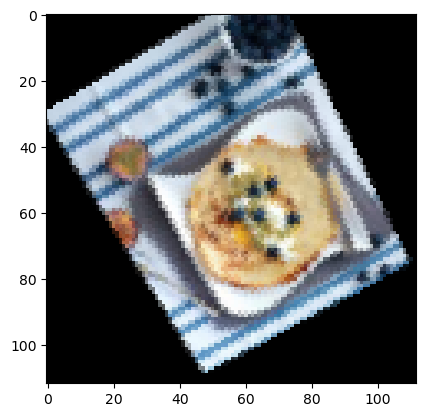

In [25]:
from torchvision import datasets, models, transforms

complete_dataset = np.asarray([[X_train[i], y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(X_train)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5, padding=2) 
        self.pool1 = nn.MaxPool2d(2, 2) # 56
        self.conv2 = nn.Conv2d(9, 27, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 28
        self.conv3 = nn.Conv2d(27, 81, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 14
        self.fc1 = nn.Linear(81 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = ConvNet()
net.to(device=device);

Epoch: 1, loss: 0.578: 100%|██████████| 83/83 [00:20<00:00,  4.13it/s]


------ Epoch 1 ------
avg. Train loss: 0.6873256607228014
Validation loss: 0.6925468494494756 | Validation accuracy: 0.5613888949155807


Epoch: 2, loss: 0.512: 100%|██████████| 83/83 [00:20<00:00,  4.09it/s]


------ Epoch 2 ------
avg. Train loss: 0.5769111212477627
Validation loss: 0.5996915400028229 | Validation accuracy: 0.7083333308498064


Epoch: 3, loss: 0.423: 100%|██████████| 83/83 [00:20<00:00,  4.09it/s]


------ Epoch 3 ------
avg. Train loss: 0.5035026464835707
Validation loss: 0.5482449072102705 | Validation accuracy: 0.7247222289443016


Epoch: 4, loss: 0.543: 100%|██████████| 83/83 [00:20<00:00,  3.98it/s]


------ Epoch 4 ------
avg. Train loss: 0.4434026727475316
Validation loss: 0.5180555569628874 | Validation accuracy: 0.746111107369264


Epoch: 5, loss: 0.314: 100%|██████████| 83/83 [00:21<00:00,  3.92it/s]


------ Epoch 5 ------
avg. Train loss: 0.3988384823483157
Validation loss: 0.5352002171178659 | Validation accuracy: 0.7411111121376356


Epoch: 6, loss: 0.37: 100%|██████████| 83/83 [00:20<00:00,  3.99it/s] 


------ Epoch 6 ------
avg. Train loss: 0.3566367159406823
Validation loss: 0.4983725386361281 | Validation accuracy: 0.7611111079653105


Epoch: 7, loss: 0.186: 100%|██████████| 83/83 [00:20<00:00,  3.99it/s] 


------ Epoch 7 ------
avg. Train loss: 0.28867255537265757
Validation loss: 0.48825997300446033 | Validation accuracy: 0.7797222211956978


Epoch: 8, loss: 0.187: 100%|██████████| 83/83 [00:20<00:00,  4.00it/s]


------ Epoch 8 ------
avg. Train loss: 0.2540006857500019
Validation loss: 0.6255948009590308 | Validation accuracy: 0.7888888865709305


Epoch: 9, loss: 0.373: 100%|██████████| 83/83 [00:20<00:00,  4.01it/s] 


------ Epoch 9 ------
avg. Train loss: 0.20680724048470878
Validation loss: 0.42761330244441825 | Validation accuracy: 0.8494444439808527


Epoch: 10, loss: 0.166: 100%|██████████| 83/83 [00:20<00:00,  3.98it/s] 


------ Epoch 10 ------
avg. Train loss: 0.17837010481091867
Validation loss: 0.5330313872545958 | Validation accuracy: 0.8233333304524422


Epoch: 11, loss: 0.266: 100%|██████████| 83/83 [00:20<00:00,  4.03it/s] 


------ Epoch 11 ------
avg. Train loss: 0.17938123436936412
Validation loss: 0.436194929604729 | Validation accuracy: 0.8319444408019384


Epoch: 12, loss: 0.271: 100%|██████████| 83/83 [00:20<00:00,  4.04it/s] 


------ Epoch 12 ------
avg. Train loss: 0.15245218745556222
Validation loss: 0.5960246821244558 | Validation accuracy: 0.7927777767181396


Epoch: 13, loss: 0.174: 100%|██████████| 83/83 [00:20<00:00,  4.02it/s] 


------ Epoch 13 ------
avg. Train loss: 0.1645592984305807
Validation loss: 0.5013712470730146 | Validation accuracy: 0.8316666632890701


Epoch: 14, loss: 0.0639: 100%|██████████| 83/83 [00:20<00:00,  4.04it/s]


------ Epoch 14 ------
avg. Train loss: 0.11508362037859049
Validation loss: 0.4518697851647933 | Validation accuracy: 0.8574999943375587


Epoch: 15, loss: 0.0156: 100%|██████████| 83/83 [00:20<00:00,  3.95it/s]


------ Epoch 15 ------
avg. Train loss: 0.12314529972801726
Validation loss: 0.39435167362292606 | Validation accuracy: 0.8724999949336052


Epoch: 16, loss: 0.2: 100%|██████████| 83/83 [00:21<00:00,  3.89it/s]   


------ Epoch 16 ------
avg. Train loss: 0.12082454099892134
Validation loss: 0.5031093892951807 | Validation accuracy: 0.8222222129503886


Epoch: 17, loss: 0.139: 100%|██████████| 83/83 [00:20<00:00,  4.05it/s] 


------ Epoch 17 ------
avg. Train loss: 0.12720536923103304
Validation loss: 0.45553002785891294 | Validation accuracy: 0.8461111014087995


Epoch: 18, loss: 0.0641: 100%|██████████| 83/83 [00:20<00:00,  4.06it/s]


------ Epoch 18 ------
avg. Train loss: 0.07650948755712395
Validation loss: 0.48293993901461363 | Validation accuracy: 0.8519444366296133


Epoch: 19, loss: 0.104: 100%|██████████| 83/83 [00:20<00:00,  4.06it/s]  


------ Epoch 19 ------
avg. Train loss: 0.0744585990344724
Validation loss: 0.6316127485285202 | Validation accuracy: 0.84444443633159


Epoch: 20, loss: 0.0602: 100%|██████████| 83/83 [00:20<00:00,  4.08it/s] 


------ Epoch 20 ------
avg. Train loss: 0.07645307925630765
Validation loss: 0.4872705501814683 | Validation accuracy: 0.8238888854781786
Finished Training


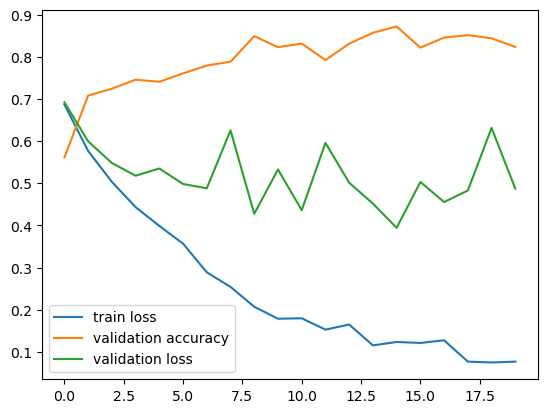

In [27]:

from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def train_model(model, optimizer, criterion=nn.CrossEntropyLoss(), epoch_count=10, batch_size=50):
    torch.manual_seed(42)
    best_acc = 0.0
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracys = []
    running_loss = []

    for epoch in range(epoch_count):  # loop over the dataset multiple times
        model.train(True)
        train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
        for i, data in enumerate(train_progress, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # print statistics
            running_loss.append(loss.item())
            train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
        
        model.train(False)
        print(f"------ Epoch {epoch+1} ------")
    
        val_loss = 0
        val_accuracy = 0
        for i, data in enumerate(valid_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
        val_loss = val_loss / len(valid_dataloader)
        val_accuracy = val_accuracy / len(valid_dataloader)
        
        val_accuracys.append(val_accuracy)
        val_losses.append(val_loss)
        train_losses.append(sum(running_loss)/(len(running_loss)))
        
        if  val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"avg. Train loss: {sum(running_loss)/(len(train_dataloader))}")
        print(f"Validation loss: {val_loss} | Validation accuracy: {val_accuracy}")
        running_loss = []

    print('Finished Training')
    plt.plot(train_losses, label='train loss')
    plt.plot(val_accuracys, label='validation accuracy')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    
    model.load_state_dict(best_model_wts)
    
    return model

train_model(net, optim.Adam(net.parameters(), lr=0.001), epoch_count=20);

In [20]:
from torchmetrics.classification import MulticlassConfusionMatrix

def test_model(model, valid_dataloader, criterion=nn.CrossEntropyLoss()):
    model.train(False)
    val_loss = 0
    val_accuracy = 0
    targets = []
    preds = []

    #valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        preds.append(outputs.argmax(dim=1))
        targets.append(labels[0])
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
    val_loss = val_loss / len(valid_dataloader)
    val_accuracy = val_accuracy / len(valid_dataloader)

    print("accuracy: {}".format(val_accuracy))
    print("loss: {}".format(val_loss))
    model.train(True)
    
    return targets,preds

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=0)
targets, preds = test_model(net, test_dataloader)

#plot confusion matrix
cm = MulticlassConfusionMatrix(num_classes=2)
cm.update(torch.tensor(preds), torch.tensor(targets))
print(cm.compute())

accuracy: 0.8065573770491803
loss: 0.7105453892625937
tensor([[269,  41],
        [ 77, 223]])
